<a href="https://colab.research.google.com/github/mehrnooshkarimi/GateContrib/blob/master/ICC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ STEP 1: Install and Import Required Libraries

In [1]:
# STEP 1: Install required libraries
!pip install pandas openpyxl


✅ STEP 2: Upload Your .zip File (static-1.zip)

In [2]:
# STEP 2: Upload ZIP file with object Excel files
from google.colab import files

uploaded = files.upload()


Saving static-1.zip to static-1.zip


✅ STEP 3: Extract the ZIP and Load Excel Files

In [3]:
# STEP 3: Extract and Load Excel Files into One DataFrame
import zipfile
import os
import pandas as pd

# Extract ZIP file
zip_path = "static-1.zip"
extract_dir = "radiomics_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Load and combine Excel files
all_data = []
for file in os.listdir(extract_dir):
    if file.endswith('.xlsx'):
        object_id = int(file.replace('object', '').replace('.xlsx', ''))
        df = pd.read_excel(os.path.join(extract_dir, file))
        df['object_id'] = object_id
        all_data.append(df)

# Combine into single DataFrame
df_full = pd.concat(all_data, ignore_index=True)

# Drop duplicate columns (sometimes 'Target_ contrast' appears twice)
df_full = df_full.loc[:, ~df_full.columns.duplicated()]

# Show basic info
print("Shape of combined DataFrame:", df_full.shape)
print(df_full[['object_id', 'Target_ contrast']].head())


Shape of combined DataFrame: (870, 83)
   object_id  Target_ contrast
0          9               1.0
1          9               1.0
2          9               1.0
3          9               1.0
4          9               1.0


✅ STEP 4: Prepare Data for ICC Calculation

In [4]:
# STEP 4: Prepare Data for ICC Calculation

# Drop rows with missing Target_ contrast (if any)
df_clean = df_full.dropna(subset=["Target_ contrast"])

# Extract only feature columns (remove IDs and metadata)
non_feature_cols = ["id", "Target_ contrast", "object_id"]
feature_cols = [col for col in df_clean.columns if col not in non_feature_cols]

# Show how many features we'll analyze
print(f"Number of radiomics features: {len(feature_cols)}")
print("Sample features:", feature_cols[:5])


Number of radiomics features: 80
Sample features: ['shape_Elongation', 'shape_Flatness', 'shape_LeastAxisLength', 'shape_MajorAxisLength', 'shape_Maximum2DDiameterColumn']


✅ STEP 5: Compute ICC (Intra-class Correlation Coefficient)

In [5]:
# STEP 5: Compute ICC for each radiomics feature
!pip install pingouin

import pingouin as pg
icc_results = []

# Loop through each feature and calculate ICC
for feature in feature_cols:
    df_icc = df_clean[[feature, "object_id"]].copy()
    df_icc["scan_id"] = df_clean.groupby("object_id").cumcount()  # Repeated measures

    # Rename for pingouin: 'targets', 'raters', 'scores'
    df_icc = df_icc.rename(columns={
        "object_id": "targets",
        "scan_id": "raters",
        feature: "scores"
    })

    try:
        icc = pg.intraclass_corr(data=df_icc, targets='targets', raters='raters', ratings='scores')
        icc_value = icc.loc[icc['Type'] == 'ICC2', 'ICC'].values[0]
        icc_results.append((feature, icc_value))
    except Exception as e:
        print(f"Error with feature {feature}: {e}")
        icc_results.append((feature, None))

# Convert to DataFrame
df_icc_result = pd.DataFrame(icc_results, columns=["Feature", "ICC2"])
df_icc_result = df_icc_result.sort_values(by="ICC2", ascending=False)

# Show top features
df_icc_result.head(10)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.3 MB/s eta 0:00:00
Error with feature ngtdm_Strength: Either missing values are present in data or data are unbalanced. Please remove them manually or use nan_policy='omit'.
Error with feature Target_ contrast : Data must have at least 5 non-missing values.


,Feature,ICC2
53,glrlm_GrayLevelNonUniformity,0.870421
1,shape_Flatness,0.861533
0,shape_Elongation,0.858753
2,shape_LeastAxisLength,0.855853
9,shape_MinorAxisLength,0.855119
16,firstorder_Energy,0.853614
27,firstorder_TotalEnergy,0.853614
8,shape_MeshVolume,0.848176
13,shape_VoxelVolume,0.848168
23,firstorder_Median,0.846296


✅ STEP 6: Save ICC Results to Excel and Download

In [6]:
# STEP 6: Save ICC results to Excel
icc_excel_path = "ICC_results.xlsx"
df_icc_result.to_excel(icc_excel_path, index=False)

# Download the file
from google.colab import files
files.download(icc_excel_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

# Path to saved ICC file in your Colab session
icc_path = "ICC_results.xlsx"

# Load workbook and apply highlights again
wb = load_workbook(icc_path)
ws = wb.active

# Define fills
yellow_fill = PatternFill(start_color='FFFF00', end_color='FFFF00', fill_type='solid')
red_fill = PatternFill(start_color='FF0000', end_color='FF0000', fill_type='solid')

# Apply coloring
for row in range(2, ws.max_row + 1):
    icc_val = ws[f'B{row}'].value
    if icc_val is not None:
        if 0.7 <= icc_val < 0.9:
            ws[f'B{row}'].fill = yellow_fill
        elif icc_val >= 0.9:
            ws[f'B{row}'].fill = red_fill

# Save with new name
highlighted_path = "ICC_results_highlighted.xlsx"
wb.save(highlighted_path)

# Download
from google.colab import files
files.download(highlighted_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

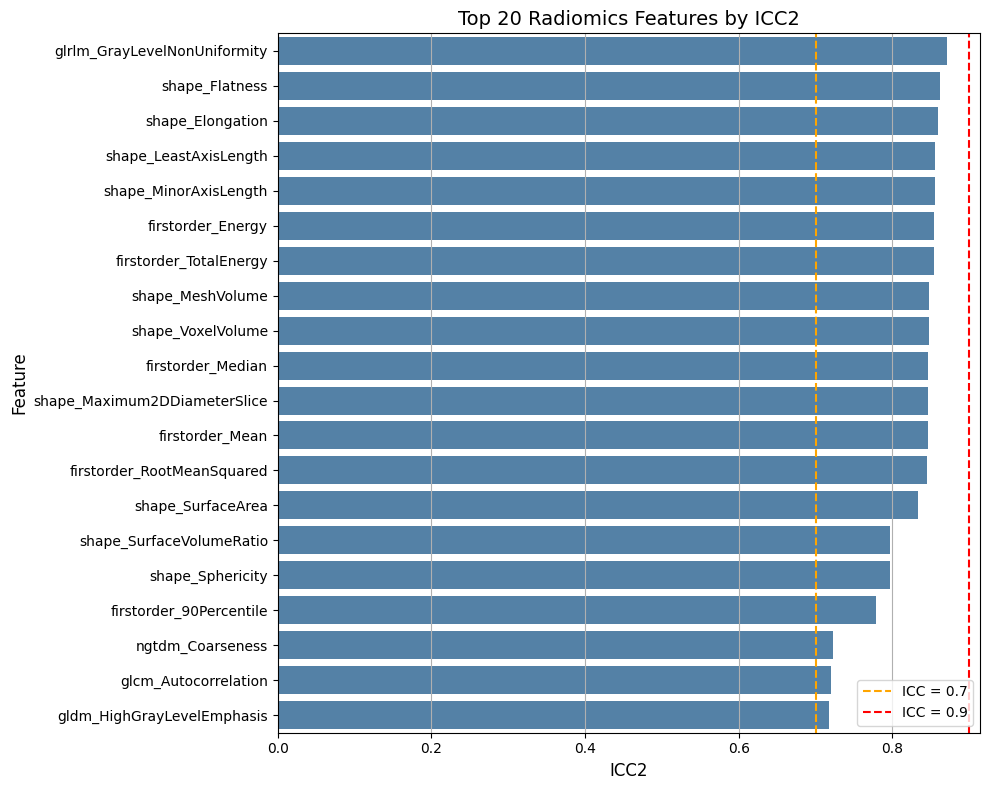

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# If needed, re-sort
df_icc_result = df_icc_result.sort_values(by="ICC2", ascending=False)
top_icc_features = df_icc_result.head(20).copy()

# Bar chart
plt.figure(figsize=(10, 8))
sns.barplot(data=top_icc_features, x="ICC2", y="Feature", color='steelblue')
plt.title("Top 20 Radiomics Features by ICC2", fontsize=14)
plt.xlabel("ICC2", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.axvline(0.7, color='orange', linestyle='--', label='ICC = 0.7')
plt.axvline(0.9, color='red', linestyle='--', label='ICC = 0.9')
plt.legend()
plt.grid(axis='x')
plt.tight_layout()
plt.show()


✅ STEP 1: COBAT: Upload Your Metadata CSV

In [9]:
from google.colab import files
uploaded = files.upload()


Saving Scan_Metadata_for_ComBat.csv to Scan_Metadata_for_ComBat.csv


✅ STEP 2: Install neuroCombat (for ComBat harmonization)

In [10]:
!pip install neuroHarmonize


✅ STEP 3: Prepare Data for Harmonization

In [11]:
import pandas as pd

# Load metadata
meta = pd.read_csv("Scan_Metadata_for_ComBat.csv")
print("Metadata shape:", meta.shape)
print("Metadata preview:")
display(meta.head())

# Check for expected columns
print("\nColumn names:", meta.columns.tolist())


Metadata shape: (29, 5)
Metadata preview:


,id,kV,mA,rotation_DDC,batch
0,2262,80,541,0,80_541_0
1,2263,100,541,0,100_541_0
2,2264,120,541,0,120_541_0
3,2265,140,462,0,140_462_0
4,2266,120,541,0,120_541_0



Column names: ['id', 'kV', 'mA', 'rotation_DDC', 'batch']


✅ STEP 4: Merge Metadata with Radiomics Features

In [12]:
# Merge metadata into radiomics dataframe
df_merged = pd.merge(df_clean, meta, on='id', how='left')

# Check shape and preview
print("Merged shape:", df_merged.shape)
print(df_merged[['id', 'object_id', 'kV', 'mA', 'rotation_DDC', 'batch']].head())


Merged shape: (812, 87)
     id  object_id   kV   mA  rotation_DDC      batch
0  2262          9   80  541             0   80_541_0
1  2263          9  100  541             0  100_541_0
2  2264          9  120  541             0  120_541_0
3  2265          9  140  462             0  140_462_0
4  2266          9  120  541             0  120_541_0


In [13]:
# Save merged DataFrame to Excel
merged_excel_path = "Radiomics_with_Metadata.xlsx"
df_merged.to_excel(merged_excel_path, index=False)

# Download it
from google.colab import files
files.download(merged_excel_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ STEP 6: Run ComBat Harmonization

In [27]:
# Merge metadata into radiomics data
df_merged = pd.merge(df_clean, meta, on='id', how='left')


In [28]:
# Install pycombat
!pip install pycombat

# Import required libraries
from pycombat import Combat
import pandas as pd
from google.colab import files
